# Fun with Neural Nets
# Part 2 - Keras CNN

---

Below is a procedure for building a neural network to recognize handwritten digits.  The data is from Kaggle, and you will submit your results to Kaggle to test how well you did!

1. Load the training data (`train.csv`) from Kaggle
2. Setup X and y (feature matrix and target vector)
3. Split X and y into train and test subsets.
4. Preprocess your data

   - When dealing with image data, you need to normalize your `X` by dividing each value by the max value of a pixel (255).
   - Since this is a multiclass classification problem, keras needs `y` to be a one-hot encoded matrix
   
5. Create your network.

   - Remember that for multi-class classification you need a softamx activation function on the output layer.
   - You may want to consider using regularization or dropout to improve performance.
   
6. Trian your network.
7. If you are unhappy with your model performance, try to tighten up your model by adding hidden layers, adding hidden layer units, chaning the activation functions on the hidden layers, etc.
8. Load in Kaggle's `test.csv`
9. Create your predictions (these should be numbers in the range 0-9).
10. Save your predictions and submit them to Kaggle.

---

For this lab, you should complete the above sequence of steps for _at least_ two of the three "configurations":

1. Using a `tensorflow` network
2. Using a `keras` "sequential" network
3. Using a `keras` convolutional network
4. Using a `tensorflow` convolutional network (we did _not_ cover this in class!)

### Import Libraries

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

%matplotlib inline

# Note if the version of tensorflow is 2.0, the original following import statement 
# "from keras.models import Sequential"will leads to an error when run "model = Sequential()".
# Solution is add "tensorflow." in front of keras as abvoe.

### Load Data

In [166]:
df = pd.read_csv('./data/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### EDA

In [167]:
print(f'Train set dimension: {df.shape}')
print(f'Missing value: {df.isnull().sum().sum()}')

Train set dimension: (42000, 785)
Missing value: 0


In [168]:
df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

### X and y

In [169]:
X = df.loc[:,'pixel0':]
y = df['label']

In [170]:
print(f'X dimension: {X.shape}')
print(f'y dimension: {y.shape}')

X dimension: (42000, 784)
y dimension: (42000,)


In [172]:
X.values.astype(float)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Preprocessing

#### Normalize X & One Hot Encoding y

In [173]:
# Normalize X by dividing each pixel by 255
X = X.values.astype(float)
X /= 255.0
X = X.reshape(42_000, 28, 28, 1)

# One-Hot-Encoding y
y = to_categorical(y)

In [174]:
X.shape

(42000, 28, 28, 1)

In [175]:
y.shape

(42000, 10)

#### Train/Test Split

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Modeling

In [149]:
# Customized callback functions
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>.9999):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True            
callbacks=myCallback()

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

# Instantiate Keras Sequential model
model = Sequential()

# Convolutional layer.
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten 
model.add(Flatten())

# Hidden Layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit model on training set and validate on test set
hist = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=40,
                 verbose=1,
                 validation_data=(X_test, y_test),
                 callbacks=[reduce_lr, callbacks]
                 )

Train on 31500 samples, validate on 10500 samples
Epoch 1/40
31500/31500 [==============================] - 23s 736us/sample - loss: 0.8323 - acc: 0.7167 - val_loss: 0.1147 - val_acc: 0.9730
Epoch 2/40
31500/31500 [==============================] - 20s 639us/sample - loss: 0.2130 - acc: 0.9473 - val_loss: 0.0695 - val_acc: 0.9835
Epoch 3/40
31500/31500 [==============================] - 21s 654us/sample - loss: 0.1493 - acc: 0.9624 - val_loss: 0.0777 - val_acc: 0.9827
Epoch 4/40
31500/31500 [==============================] - 20s 632us/sample - loss: 0.1337 - acc: 0.9677 - val_loss: 0.0769 - val_acc: 0.9837
Epoch 5/40
31500/31500 [==============================] - 21s 662us/sample - loss: 0.1123 - acc: 0.9735 - val_loss: 0.0600 - val_acc: 0.9881
Epoch 6/40
31500/31500 [==============================] - 21s 668us/sample - loss: 0.0976 - acc: 0.9764 - val_loss: 0.0548 - val_acc: 0.9894
Epoch 7/40
31500/31500 [==============================] - 20s 651us/sample - loss: 0.0901 - acc: 0.9768 

### Model Evaluation

#### Performance Plot

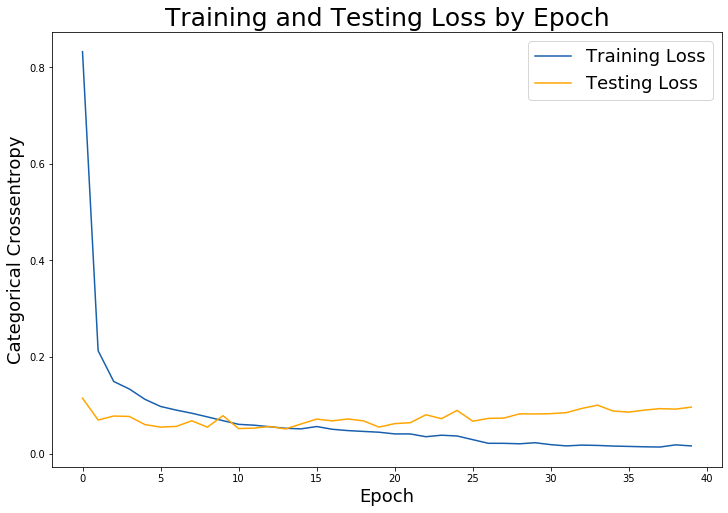

In [151]:
# Check out our train loss and test loss over epochs.
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
# plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

plt.legend(fontsize = 18);

#### Performance Stats Summary

In [152]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test, verbose=1)

labels = model.metrics_names

10500/10500 [==============================] - 2s 180us/sample - loss: 0.0962 - acc: 0.9927


In [153]:
# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

loss: 0.09619992804611348
acc: 0.9926666617393494


In [154]:
# Check out the model summary.
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 1024)              820224    
_________________________________________________________________
dropout_44 (Dropout)         (None, 1024)            

#### Misclassification Details

In [178]:
# Model predict from X_test
pred_test = model.predict_classes(X_test)

In [265]:
def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [280]:
plot_conv_weights(model, 'dense_105')

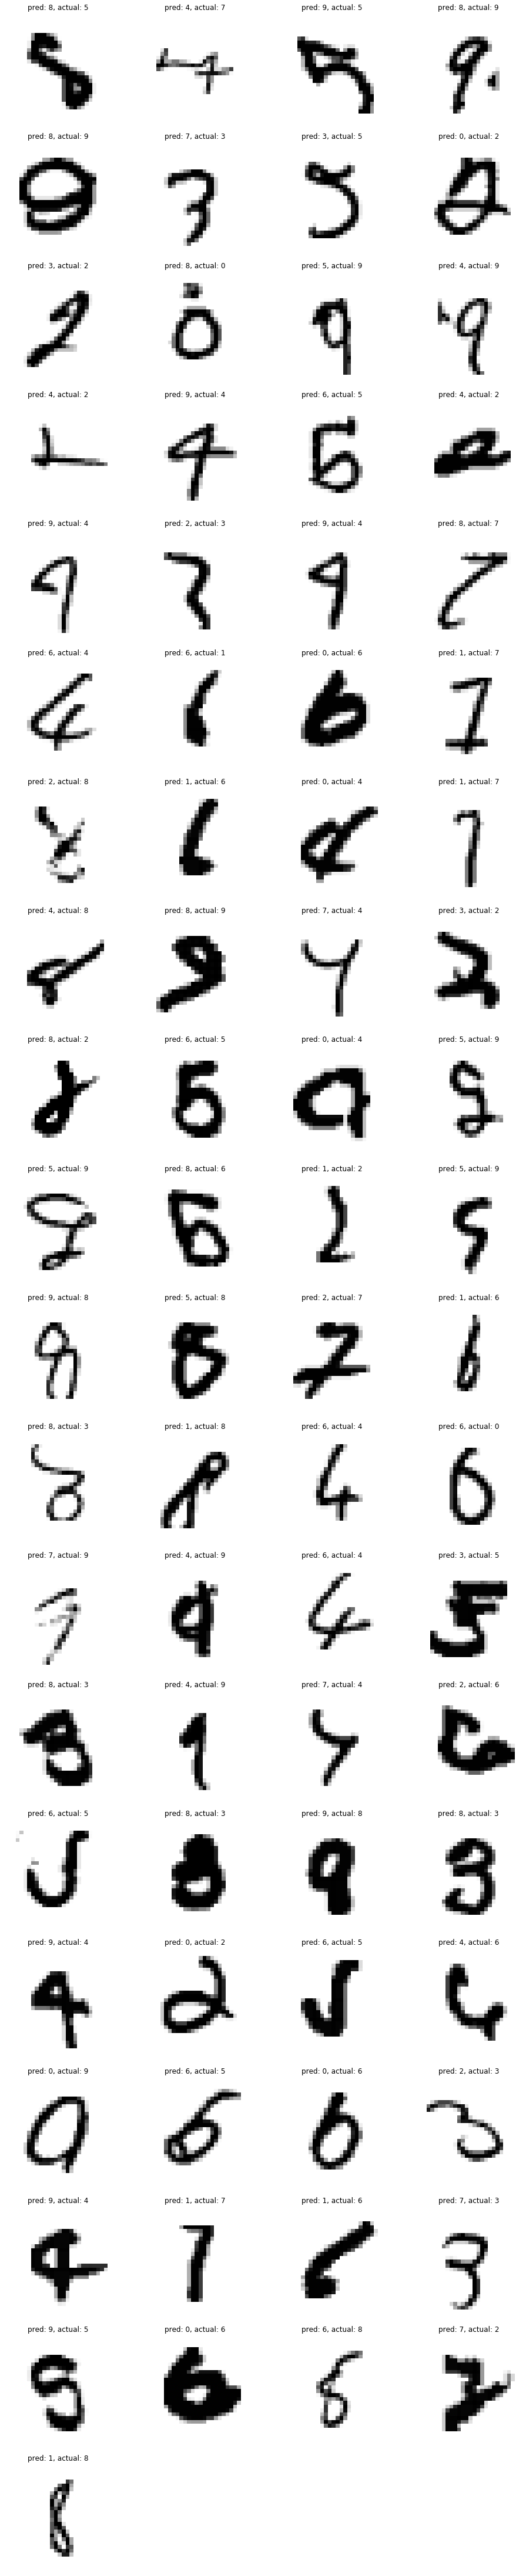

In [252]:
# Plot the misclassed numbers

# Reverse y_test from One-Hot-Encoding to classis
def reverse_y(y_test):
    y_reverse = []
    for x in y_test:
        for i, number in enumerate(x):
            if number == 1:
                y_reverse.append(i)
    return y_reverse

y_reverse = reverse_y(y_test)

# Construct a dictionary of misclassified image recognition.
def misclass(pred_test, y_reverse):
    check_images = {}
    for i, pred_class in enumerate(pred_test):
        if pred_class != y_reverse[i]:
            check_images[i] = [y_reverse[i], pred_test[i], X_test[i].reshape(28,28)*255]
    return check_images

check_images = misclass(pred_test, y_reverse)

# plot the misclassified images
def plot_misclass(check_images):
    cols = 4
    rows = len(check_images)//4+1
    fig = plt.figure(figsize=(cols*4, rows*4))
    for i, image in enumerate(check_images.values()):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(image[2], cmap='binary')
        plt.title(f'pred: {image[1]}, actual: {image[0]}')
        plt.axis('off');
        
plot_misclass(check_images)

### Remodel Using Full Training Set

In [131]:
# Customized callback functions
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>.9999):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks=myCallback()
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

# Instantiate Keras Sequential model
model = Sequential()

# Convolutional layer.
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten 
model.add(Flatten())

# Hidden Layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


# Fit model on training set
hist = model.fit(X,
                 y,
                 batch_size=256,
                 epochs=33,
                 verbose=1,
                 callbacks=[reduce_lr, callbacks]
                 )

Epoch 1/33
42000/42000 [==============================] - 25s 591us/sample - loss: 0.8409 - acc: 0.7094
Epoch 2/33
42000/42000 [==============================] - 24s 578us/sample - loss: 0.2039 - acc: 0.9490
Epoch 3/33
42000/42000 [==============================] - 25s 586us/sample - loss: 0.1484 - acc: 0.9624
Epoch 4/33
42000/42000 [==============================] - 24s 570us/sample - loss: 0.1210 - acc: 0.9712
Epoch 5/33
42000/42000 [==============================] - 24s 564us/sample - loss: 0.1076 - acc: 0.9720
Epoch 6/33
42000/42000 [==============================] - 24s 565us/sample - loss: 0.0886 - acc: 0.9769
Epoch 7/33
42000/42000 [==============================] - 23s 558us/sample - loss: 0.0771 - acc: 0.9794
Epoch 8/33
42000/42000 [==============================] - 24s 577us/sample - loss: 0.0669 - acc: 0.9831
Epoch 9/33
42000/42000 [==============================] - 24s 577us/sample - loss: 0.0599 - acc: 0.9837
Epoch 10/33
42000/42000 [==============================] - 24s 5

### Submission

In [132]:
X_sub = pd.read_csv('./data/test.csv')
X_sub = X_sub.values.astype(float)
X_sub /= 255.0
X_sub = X_sub.reshape(28000, 28, 28, 1)
X_sub.shape

(28000, 28, 28, 1)

In [133]:
pred = model.predict_classes(X_sub)

In [138]:
to_sub = pd.DataFrame(pred, columns=['Label'])
to_sub['ImageId'] = np.linspace(1, to_sub.shape[0], to_sub.shape[0]).astype(int)
to_sub = to_sub[['ImageId','Label']]
print(f'shape: {to_sub.shape}')

shape: (28000, 2)


#### Save to CSV

In [136]:
to_sub.to_csv('./submit_keras_CNN_6.csv', index=False)